In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import math

In [2]:
data = pd.read_csv('soc-sign-bitcoinotc.csv')

In [3]:
# scaling the ratings from "-10 to 10" to "-1 to 1"
min_val = -10
max_val = 10
new_min = -1
new_max = 1
data['RATING'] = ((data['RATING'] - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

In [4]:
# Function to initialize fairness and goodness scores
def initialize_scores(data):
    nodes = set(data['SOURCE']).union(data['TARGET'])
    fairness = {node: 1.0 for node in nodes}
    goodness = {node: data['RATING'].mean() for node in nodes}
    return fairness, goodness

In [5]:
data

,SOURCE,TARGET,RATING,TIME
0,6,2,0.4,1.289242e+09
1,6,5,0.2,1.289242e+09
2,1,15,0.1,1.289243e+09
3,4,3,0.7,1.289245e+09
4,13,16,0.8,1.289254e+09
...,...,...,...,...
35587,4499,1810,0.1,1.453612e+09
35588,2731,3901,0.5,1.453679e+09
35589,2731,4897,0.5,1.453679e+09
35590,13,1128,0.1,1.453680e+09


In [6]:
def compute_fairness_goodness(G, data):
    fairness, goodness = initialize_scores(data)
    
    nodes = G.nodes()
    iter_count = 0
    while iter_count < 100:
        df = 0
        dg = 0

        # Calculate goodness
        for node in nodes:
            inedges = G.in_edges(node, data=True)
            g = 0
            for edge in inedges:
                g += fairness[edge[0]] * edge[2]['weight']

            if len(inedges) > 0:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)

        # Calculate fairness
        for node in nodes:
            outedges = G.out_edges(node, data=True)
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2]['weight'] - goodness[edge[1]]) / 2.0

            if len(outedges) > 0:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
        
        # Check for convergence
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break

        iter_count += 1
    
    return fairness, goodness

In [7]:
G = nx.DiGraph()
for _, row in data.iterrows():
    G.add_edge(row['SOURCE'], row['TARGET'], weight=row['RATING'])


# Calculate fairness and goodness
fairness, goodness = compute_fairness_goodness(G, data)

# Results
fairness, goodness

({1: 0.9224364178283305,
  2: 0.8937438727755906,
  3: 1.0,
  4: 0.8912871984696537,
  5: 0.9401114372757616,
  6: 0.895725519589204,
  7: 0.9438444190253923,
  8: 0.9880334901397252,
  9: 0.6619665098602749,
  10: 0.713045549965856,
  13: 0.9455630055117719,
  15: 0.9604893190993837,
  16: 1.0,
  17: 0.9186382873341592,
  19: 0.9184778713104245,
  20: 1.0,
  21: 0.8807172099458485,
  23: 0.9347964708903963,
  25: 1.0,
  26: 0.9337386393011995,
  28: 0.9608730647843379,
  29: 0.972792447360182,
  31: 0.9723667238487769,
  32: 0.9258319700862093,
  33: 0.9418636688940842,
  34: 0.9238532955481142,
  35: 0.9830143667602697,
  36: 0.9679313502408943,
  37: 0.9445277419086083,
  39: 0.8923911541714011,
  41: 0.9621529896141624,
  44: 0.9450026744060911,
  45: 0.9228034119197933,
  46: 0.9629327604510792,
  47: 0.9276231591696986,
  51: 0.9470228936705524,
  52: 0.9591249300357105,
  53: 0.9528667309250523,
  54: 0.9215564303461556,
  55: 0.9172128281996721,
  56: 0.9674292223834459,
  57: 

In [8]:
len(fairness), len(goodness)

(5881, 5881)

In [9]:
min(goodness.values()), max(goodness.values())

(-1.0, 1.0)

In [10]:
min(fairness.values()), max(fairness.values())

(0.3199615714769132, 1.0)

In [11]:
import statistics
print("Mode Fairness: ",statistics.mode(list(fairness.values())))
print("Mode Goodness: ",statistics.mode(list(goodness.values())))

Mode Fairness:  1.0
Mode Goodness:  0.09830143667603837


In [12]:
print("Median Fairness: ",statistics.median(list(fairness.values())))
print("Median Goodness: ",statistics.median(list(goodness.values())))

Median Fairness:  0.9634176036364297
Median Goodness:  0.09753152120854487


In [13]:
print("Mean Fairness: ",statistics.mean(list(fairness.values())))
print("Mean Goodness: ",statistics.mean(list(goodness.values())))

Mean Fairness:  0.9361968968021395
Mean Goodness:  0.07051312923081243


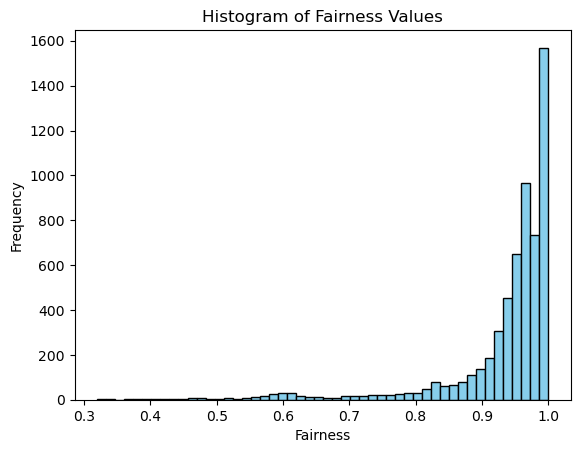

In [25]:
import matplotlib.pyplot as plt

plt.hist(list(fairness.values()), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Fairness')
plt.ylabel('Frequency')
plt.title('Histogram of Fairness Values')
plt.show()

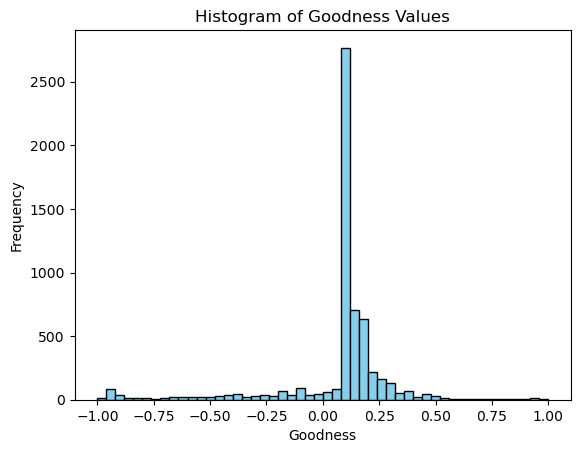

In [27]:
plt.hist(list(goodness.values()), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Goodness')
plt.ylabel('Frequency')
plt.title('Histogram of Goodness Values')
plt.show()

In [49]:
# fairness_threshold = np.percentile(list(fairness.values()), 5) # which is around 0.7
# goodness_threshold = np.percentile(list(goodness.values()), 10) # inference is from the histogram above

median_fairness, mean_fairness = statistics.median(list(fairness.values())), statistics.mean(list(fairness.values()))
median_goodness, mean_goodness = statistics.median(list(goodness.values())), statistics.mean(list(goodness.values()))
fairness_threshold = median_fairness - (median_fairness - mean_fairness) / 2
goodness_threshold = median_goodness - (median_goodness - mean_goodness) / 2


In [114]:
fraudulent_users = []
for node in fairness:
    if fairness[node] < fairness_threshold and goodness[node] < goodness_threshold:
        fraudulent_users.append(node)
        
len(fraudulent_users), fairness_threshold, goodness_threshold, (len(fraudulent_users)/len(fairness)) * 100

(434, 0.9498072502192846, 0.08402232521967865, 7.379697330385988)

In [51]:
fraudulent_users

[44,
 61,
 135,
 204,
 293,
 310,
 410,
 467,
 574,
 628,
 672,
 733,
 786,
 788,
 804,
 824,
 832,
 870,
 905,
 906,
 957,
 958,
 1026,
 1074,
 1139,
 1143,
 1145,
 1197,
 1272,
 1277,
 1293,
 1318,
 1329,
 1331,
 1363,
 1383,
 1510,
 1543,
 1572,
 1647,
 1662,
 1671,
 1703,
 1719,
 1726,
 1792,
 1815,
 1984,
 2028,
 2044,
 2045,
 2096,
 2158,
 2194,
 2211,
 2229,
 2261,
 2266,
 2293,
 2322,
 2363,
 2367,
 2410,
 2471,
 2505,
 2514,
 2516,
 2517,
 2524,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2549,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2581,
 2585,
 2591,
 2592,
 2597,
 2598,
 2601,
 2603,
 2622,
 2623,
 2628,
 2631,
 2632,
 2636,
 2640,
 2657,
 2661,
 2666,
 2669,
 2670,
 2671,
 2672,
 2674,
 2675,
 2676,
 2677,
 2678,
 2680,
 2682,
 2683,
 2684,
 2688,
 2694,
 2695,
 2699,
 2700,
 2701,
 2702,
 2703,
 2704,
 2705,
 2712,
 2717,
 2718,
 2720,
 2726,
 2735,
 2736,
 2737,
 2738,
 2744,
 2745,
 2746,
 2747,
 2757,
 2766,
 2778,
 2787,
 2788,
 2796,
 2

In [52]:
len(fraudulent_users)

434

# Community Detection

In [34]:
import community

In [40]:
G_undirected = nx.DiGraph()
for _, row in data.iterrows():
    G_undirected.add_edge(row['SOURCE'], row['TARGET'])

G_undirected = G_undirected.to_undirected()

In [41]:
dendrogram = community.generate_dendrogram(G_undirected)
for level in range(len(dendrogram)) :
    print("partition at level", level, "is", community.partition_at_level(dendrogram, level))
    print(set(community.partition_at_level(dendrogram, level).values()))

partition at level 0 is {6.0: 554, 2.0: 123, 5.0: 554, 1.0: 554, 15.0: 554, 4.0: 554, 3.0: 417, 13.0: 554, 16.0: 554, 10.0: 9, 7.0: 10, 21.0: 9, 20.0: 560, 8.0: 9, 17.0: 243, 23.0: 416, 25.0: 554, 26.0: 701, 28.0: 554, 29.0: 19, 31.0: 554, 32.0: 554, 34.0: 554, 35.0: 23, 36.0: 24, 37.0: 554, 44.0: 554, 39.0: 123, 45.0: 369, 19.0: 554, 46.0: 24, 47.0: 10, 51.0: 609, 52.0: 19, 53.0: 369, 54.0: 554, 41.0: 36, 55.0: 10, 57.0: 554, 61.0: 554, 65.0: 23, 56.0: 82, 66.0: 554, 69.0: 582, 70.0: 65, 71.0: 554, 72.0: 554, 74.0: 554, 75.0: 48, 68.0: 67, 64.0: 554, 76.0: 554, 77.0: 554, 78.0: 53, 60.0: 54, 79.0: 23, 80.0: 554, 81.0: 243, 62.0: 582, 83.0: 36, 104.0: 554, 86.0: 36, 87.0: 54, 89.0: 36, 94.0: 554, 95.0: 65, 96.0: 609, 97.0: 67, 99.0: 582, 88.0: 544, 101.0: 72, 100.0: 72, 103.0: 72, 105.0: 212, 106.0: 609, 107.0: 243, 108.0: 230, 109.0: 77, 110.0: 554, 111.0: 441, 112.0: 554, 115.0: 582, 114.0: 82, 119.0: 554, 122.0: 53, 127.0: 89, 129.0: 554, 116.0: 10, 131.0: 554, 132.0: 89, 133.0: 10,

size of the best partition:  22.0


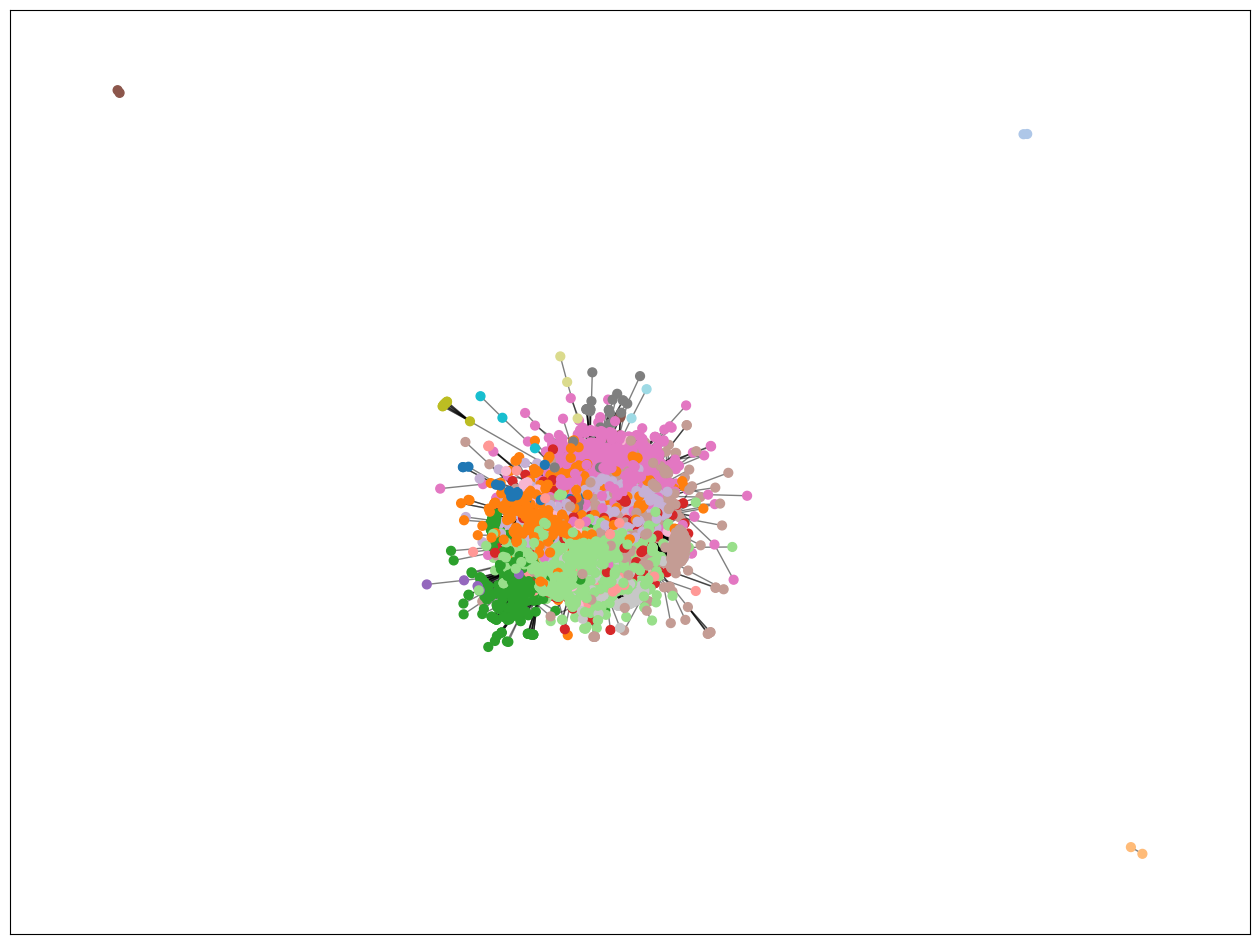

In [44]:
plt.figure(figsize=(16, 12))

partition = community.best_partition(G_undirected)

size = float(len(set(partition.values())))
print('size of the best partition: ',size)
pos = nx.spring_layout(G_undirected)
node_list = [n for n, n_com in sorted(partition.items())]
node_colors = [n_com for n, n_com in sorted(partition.items())]
    
nx.draw_networkx_nodes(G_undirected, pos, node_list, node_size=40, 
                       vmin=0, vmax=size,
                       node_color=node_colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5)
plt.show()

In [45]:
partition

{6.0: 14,
 2.0: 14,
 5.0: 14,
 1.0: 14,
 15.0: 14,
 4.0: 14,
 3.0: 14,
 13.0: 14,
 16.0: 14,
 10.0: 14,
 7.0: 14,
 21.0: 14,
 20.0: 14,
 8.0: 14,
 17.0: 14,
 23.0: 14,
 25.0: 6,
 26.0: 14,
 28.0: 14,
 29.0: 14,
 31.0: 14,
 32.0: 14,
 34.0: 14,
 35.0: 13,
 36.0: 3,
 37.0: 14,
 44.0: 14,
 39.0: 14,
 45.0: 14,
 19.0: 14,
 46.0: 3,
 47.0: 14,
 51.0: 6,
 52.0: 14,
 53.0: 14,
 54.0: 14,
 41.0: 14,
 55.0: 14,
 57.0: 6,
 61.0: 14,
 65.0: 13,
 56.0: 14,
 66.0: 14,
 69.0: 14,
 70.0: 13,
 71.0: 14,
 72.0: 14,
 74.0: 14,
 75.0: 14,
 68.0: 14,
 64.0: 14,
 76.0: 14,
 77.0: 14,
 78.0: 14,
 60.0: 14,
 79.0: 13,
 80.0: 14,
 81.0: 14,
 62.0: 14,
 83.0: 14,
 104.0: 14,
 86.0: 14,
 87.0: 14,
 89.0: 14,
 94.0: 14,
 95.0: 13,
 96.0: 6,
 97.0: 14,
 99.0: 14,
 88.0: 14,
 101.0: 14,
 100.0: 14,
 103.0: 14,
 105.0: 14,
 106.0: 6,
 107.0: 14,
 108.0: 14,
 109.0: 14,
 110.0: 14,
 111.0: 14,
 112.0: 14,
 115.0: 3,
 114.0: 14,
 119.0: 14,
 122.0: 14,
 127.0: 14,
 129.0: 14,
 116.0: 14,
 131.0: 14,
 132.0: 14,
 133.

In [53]:
from collections import Counter

# Count occurrences of each community ID among fraudulent users
fraudulent_community_counts = Counter(partition[user] for user in fraudulent_users if user in partition)

# Find the community ID with the highest count
most_common_community_id = fraudulent_community_counts.most_common(1)[0][0]

print("Most common community ID among fraudulent users:", most_common_community_id)
print(fraudulent_community_counts)

Most common community ID among fraudulent users: 8
Counter({8: 136, 6: 112, 7: 48, 17: 36, 14: 34, 3: 23, 10: 20, 5: 13, 13: 7, 15: 3, 16: 2})


In [54]:
# Initialize a Counter to store the count of fraudulent users in each community
fraudulent_users_per_community = Counter()

# Count fraudulent users in each community
for user in fraudulent_users:
    if user in partition:
        community_id = partition[user]
        fraudulent_users_per_community[community_id] += 1

# Display the count of fraudulent users in each community
for community_id, count in fraudulent_users_per_community.items():
    print(f"Community {community_id}: {count} fraudulent users")

Community 14: 34 fraudulent users
Community 16: 2 fraudulent users
Community 3: 23 fraudulent users
Community 10: 20 fraudulent users
Community 5: 13 fraudulent users
Community 8: 136 fraudulent users
Community 13: 7 fraudulent users
Community 6: 112 fraudulent users
Community 7: 48 fraudulent users
Community 17: 36 fraudulent users
Community 15: 3 fraudulent users


In [57]:
total_users_per_community = Counter(partition.values())

fraudulent_percentage_per_community = {}

for community_id, fraudulent_count in fraudulent_users_per_community.items():
    total_users = total_users_per_community[community_id]
    fraudulent_percentage = (fraudulent_count / total_users) * 100
    fraudulent_percentage_per_community[community_id] = fraudulent_percentage

for community_id, percentage in fraudulent_percentage_per_community.items():
    total_users = total_users_per_community[community_id]
    print(f"Community {community_id}: Length = {total_users}, Percentage of fraudulent users = {percentage:.2f}%")

Community 14: Length = 1265, Percentage of fraudulent users = 2.69%
Community 16: Length = 44, Percentage of fraudulent users = 4.55%
Community 3: Length = 523, Percentage of fraudulent users = 4.40%
Community 10: Length = 642, Percentage of fraudulent users = 3.12%
Community 5: Length = 518, Percentage of fraudulent users = 2.51%
Community 8: Length = 329, Percentage of fraudulent users = 41.34%
Community 13: Length = 588, Percentage of fraudulent users = 1.19%
Community 6: Length = 1096, Percentage of fraudulent users = 10.22%
Community 7: Length = 539, Percentage of fraudulent users = 8.91%
Community 17: Length = 211, Percentage of fraudulent users = 17.06%
Community 15: Length = 57, Percentage of fraudulent users = 5.26%


In [100]:
def analyze_community_structure(G, communities, fraudulent_users):
    results = {}
    for idx, nodes in communities.items():
        subgraph = G.subgraph(nodes)
        fraudulent_count = len([node for node in nodes if node in fraudulent_users])
        total_count = len(nodes)
        fraud_percentage = (fraudulent_count / total_count) * 100 if total_count > 0 else 0
        
        results[idx] = {
            'size': total_count,
            'edge_count': subgraph.number_of_edges(),
            'density': nx.density(subgraph),
            'diameter': nx.diameter(subgraph) if nx.is_connected(subgraph) else float('inf'),
            'average_degree': sum(dict(subgraph.degree()).values()) / total_count,
            'clustering_coefficient': nx.average_clustering(subgraph),
            'average_path_length': nx.average_shortest_path_length(subgraph) if len(nodes) > 1 else 0,
            'percentage_fraudulent': fraud_percentage,  # Added attribute
        }
    return results



# Here we organize nodes according to communities
community_nodes = {comm: [nodes for nodes in partition.keys() if partition[nodes] == comm] for comm in set(partition.values())}
top_communities = sorted(community_nodes.items(), key=lambda x: len(x[1]), reverse=True)


community_stats = analyze_community_structure(G_undirected, dict(top_communities), fraudulent_users)

for idx, stats in community_stats.items():
    print(f"Community {idx}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name.replace('_', ' ').title()}: {value}")

Community 14:
  Size: 1265
  Edge Count: 3634
  Density: 0.004545454545454545
  Diameter: 8
  Average Degree: 5.745454545454545
  Clustering Coefficient: 0.12197590680442158
  Average Path Length: 3.547989943463251
  Percentage Fraudulent: 2.6877470355731226
Community 6:
  Size: 1096
  Edge Count: 3713
  Density: 0.006187714561877146
  Diameter: 7
  Average Degree: 6.775547445255475
  Clustering Coefficient: 0.20175335941315803
  Average Path Length: 3.2235659767356597
  Percentage Fraudulent: 10.218978102189782
Community 10:
  Size: 642
  Edge Count: 1230
  Density: 0.005977809205826177
  Diameter: 8
  Average Degree: 3.8317757009345796
  Clustering Coefficient: 0.11762771436109251
  Average Path Length: 3.4255957154174017
  Percentage Fraudulent: 3.115264797507788
Community 13:
  Size: 588
  Edge Count: 672
  Density: 0.0038938914577756143
  Diameter: 10
  Average Degree: 2.2857142857142856
  Clustering Coefficient: 0.0611471611394933
  Average Path Length: 2.816784294637787
  Percen

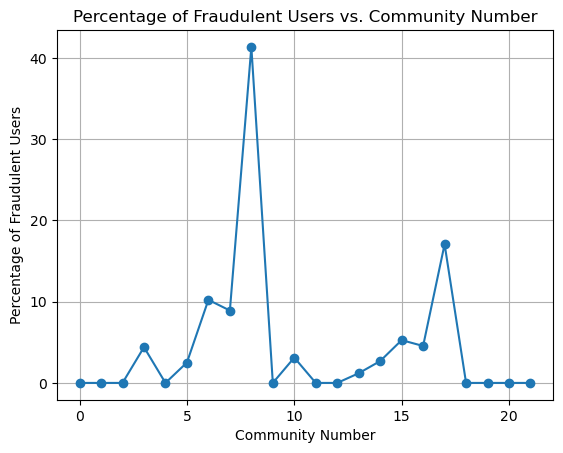

In [115]:
community_numbers = sorted(community_stats.keys())
fraudulent_percentages = [community_stats[idx]['percentage_fraudulent'] for idx in community_numbers]

# Create a line plot
plt.plot(community_numbers, fraudulent_percentages, marker='o', linestyle='-')
plt.xlabel('Community Number')
plt.ylabel('Percentage of Fraudulent Users')
plt.title('Percentage of Fraudulent Users vs. Community Number')
plt.grid(True)
plt.show()

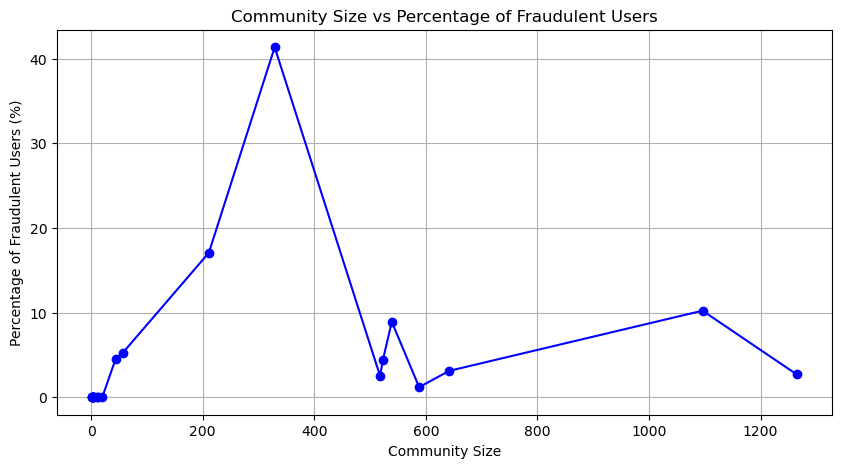

In [102]:
sorted_communities = sorted(community_stats.items(), key=lambda item: item[1]['size'])
sizes = [community['size'] for idx, community in sorted_communities]
fraud_percentages = [community['percentage_fraudulent'] for idx, community in sorted_communities]

plt.figure(figsize=(10, 5))
plt.plot(sizes, fraud_percentages, marker='o', linestyle='-', color='blue')
plt.title('Community Size vs Percentage of Fraudulent Users')
plt.xlabel('Community Size')
plt.ylabel('Percentage of Fraudulent Users (%)')
plt.grid(True)
plt.show()

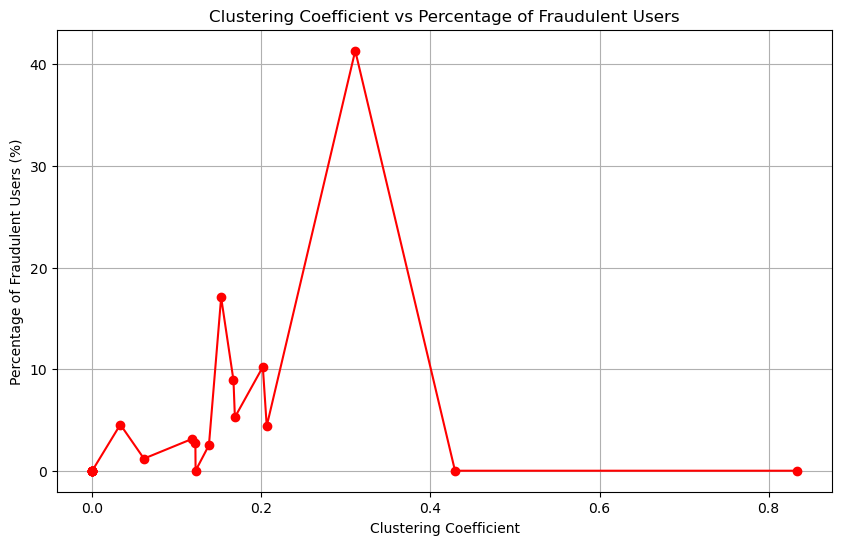

In [104]:
clustering_coeffs = [stats['clustering_coefficient'] for stats in community_stats.values()]
fraud_percentages = [stats['percentage_fraudulent'] for stats in community_stats.values()]

sorted_indices = sorted(range(len(clustering_coeffs)), key=lambda k: clustering_coeffs[k])
sorted_clustering_coeffs = [clustering_coeffs[i] for i in sorted_indices]
sorted_fraud_percentages = [fraud_percentages[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(sorted_clustering_coeffs, sorted_fraud_percentages, marker='o', linestyle='-', color='red')
plt.title('Clustering Coefficient vs Percentage of Fraudulent Users')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Percentage of Fraudulent Users (%)')
plt.grid(True)
plt.show()

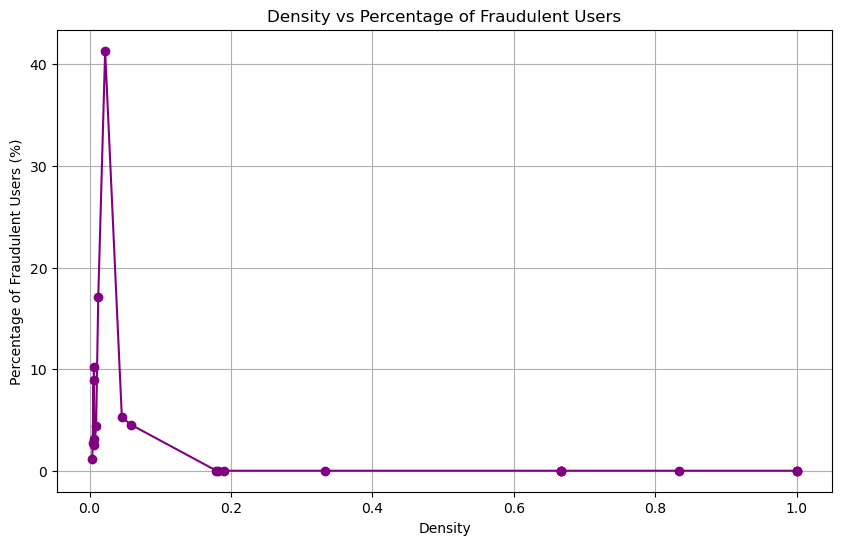

In [105]:
densities = [stats['density'] for stats in community_stats.values()]
fraud_percentages = [stats['percentage_fraudulent'] for stats in community_stats.values()]

sorted_indices_by_density = sorted(range(len(densities)), key=lambda k: densities[k])
sorted_densities = [densities[i] for i in sorted_indices_by_density]
sorted_fraud_percentages_by_density = [fraud_percentages[i] for i in sorted_indices_by_density]

plt.figure(figsize=(10, 6))
plt.plot(sorted_densities, sorted_fraud_percentages_by_density, marker='o', linestyle='-', color='purple')
plt.title('Density vs Percentage of Fraudulent Users')
plt.xlabel('Density')
plt.ylabel('Percentage of Fraudulent Users (%)')
plt.grid(True)
plt.show()

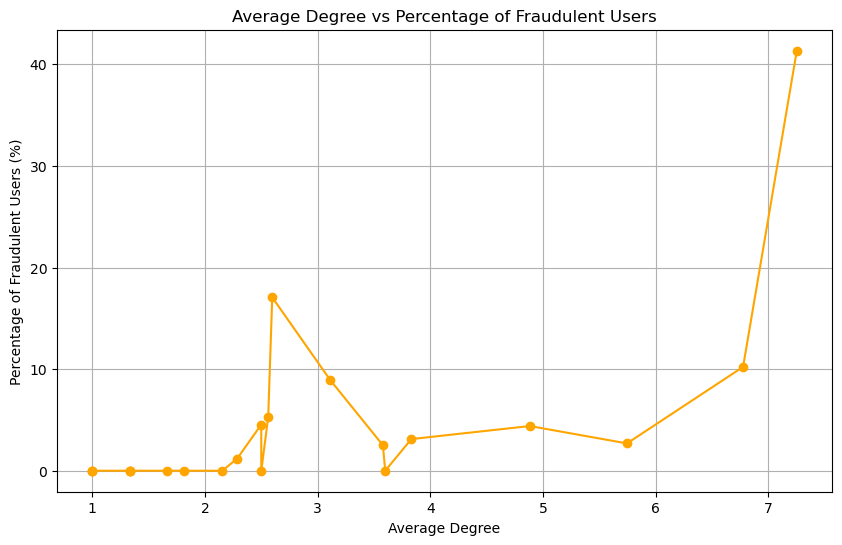

In [106]:
average_degrees = [stats['average_degree'] for stats in community_stats.values()]
fraud_percentages = [stats['percentage_fraudulent'] for stats in community_stats.values()]

sorted_indices = sorted(range(len(average_degrees)), key=lambda k: average_degrees[k])
sorted_average_degrees = [average_degrees[i] for i in sorted_indices]
sorted_fraud_percentages = [fraud_percentages[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(sorted_average_degrees, sorted_fraud_percentages, marker='o', linestyle='-', color='orange')
plt.title('Average Degree vs Percentage of Fraudulent Users')
plt.xlabel('Average Degree')
plt.ylabel('Percentage of Fraudulent Users (%)')
plt.grid(True)
plt.show()

# Clustering Coefficient Comparison

In [98]:
overall_clustering_coefficient = nx.average_clustering(G_undirected)

fraudulent_users_subgraph = G_undirected.subgraph(fraudulent_users)
fraudulent_users_clustering_coefficient = nx.average_clustering(G_undirected, nodes=fraudulent_users)

# Print the results
print("Average clustering coefficient:", overall_clustering_coefficient)
print("Average clustering coefficient of fraudulent users:", fraudulent_users_clustering_coefficient)


Average clustering coefficient: 0.17750449405289517
Average clustering coefficient of fraudulent users: 0.3782960486840457


# Centrality Comparison

In [62]:
degree_centrality = nx.degree_centrality(G_undirected)

In [63]:
average_centrality_all = sum(degree_centrality.values()) / len(degree_centrality)

fraudulent_users_centrality = [degree_centrality[user] for user in fraudulent_users]
average_centrality_fraudulent = sum(fraudulent_users_centrality) / len(fraudulent_users)

# Print the results
print("Average centrality of all nodes:", average_centrality_all)
print("Average centrality of fraudulent users:", average_centrality_fraudulent)


Average centrality of all nodes: 0.0012430205886130013
Average centrality of fraudulent users: 0.0024620677764193204


In [64]:
betweenness_centrality = nx.betweenness_centrality(G_undirected)

In [65]:
average_centrality_all = sum(betweenness_centrality.values()) / len(betweenness_centrality)

fraudulent_users_centrality = [betweenness_centrality[user] for user in fraudulent_users]
average_centrality_fraudulent = sum(fraudulent_users_centrality) / len(fraudulent_users)

# Print the results
print("Average betweenness centrality of all nodes:", average_centrality_all)
print("Average betweenness centrality of fraudulent users:", average_centrality_fraudulent)


Average betweenness centrality of all nodes: 0.0004364422227851438
Average betweenness centrality of fraudulent users: 0.0006677238247734651


In [68]:
closeness_centrality = nx.closeness_centrality(G_undirected)

In [69]:
average_centrality_all = sum(closeness_centrality.values()) / len(closeness_centrality)

fraudulent_users_centrality = [closeness_centrality[user] for user in fraudulent_users]
average_centrality_fraudulent = sum(fraudulent_users_centrality) / len(fraudulent_users)

# Print the results
print("Average closeness centrality of all nodes:", average_centrality_all)
print("Average closeness centrality of fraudulent users:", average_centrality_fraudulent)


Average closeness centrality of all nodes: 0.28389287710450595
Average closeness centrality of fraudulent users: 0.30350685113535886


# Strongly and Weakly Connected Components

In [110]:
sg = nx.strongly_connected_components(G)

component_sizes = []
fraudulent_user_percentages = []
normalized_sizes = []
total_nodes = len(G.nodes())

for component in sg:
    total_nodes_in_component = len(component)
    fraudulent_users_in_component = [user for user in component if user in fraudulent_users]
    if total_nodes_in_component > 0 and len(fraudulent_users_in_component) > 0:
        percentage_fraudulent_users = (len(fraudulent_users_in_component) / total_nodes_in_component) * 100
        component_sizes.append(total_nodes_in_component)
        fraudulent_user_percentages.append(percentage_fraudulent_users)
        normalized_sizes.append(total_nodes_in_component / total_nodes)
        print("Connected Component: ", component)
        print("Percentage of fraudulent users in strongly connected component:", percentage_fraudulent_users)
        

Connected Component:  {1329.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2694.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2695.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2704.0, 2705.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2703.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2746.0, 2747.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2745.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2744.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2736.0, 2735.0}
Percentage of fraudulent users in strongly connected component: 100.0
Connected Component:  {2712.0, 2717.0, 2718.0}
Percentage of fraudu

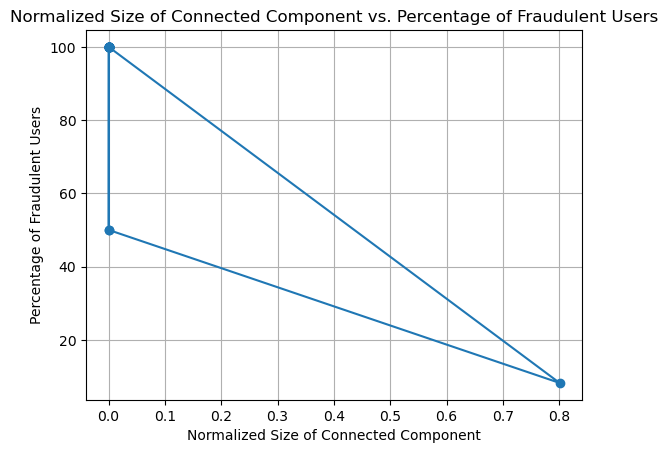

In [111]:
plt.plot(normalized_sizes, fraudulent_user_percentages, marker='o', linestyle='-')
plt.xlabel('Normalized Size of Connected Component')
plt.ylabel('Percentage of Fraudulent Users')
plt.title('Normalized Size of Connected Component vs. Percentage of Fraudulent Users')
plt.grid(True)
plt.show()

In [82]:
wg = nx.weakly_connected_components(G)
for component in wg:
    total_nodes_in_component = len(component)
    fraudulent_users_in_component = [user for user in component if user in fraudulent_users]
    if total_nodes_in_component > 0 and len(fraudulent_users_in_component) > 0:
        percentage_fraudulent_users = (len(fraudulent_users_in_component) / total_nodes_in_component) * 100
        print("Percentage of fraudulent users in weakly connected component:", percentage_fraudulent_users)

Percentage of fraudulent users in weakly connected component: 7.387234042553191


In [84]:
nx.number_connected_components(G_undirected)

4